## Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# %matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

cv2.destroyAllWindows()

In [2]:
import pickle

# Do camera calibration given object points and image points
img = cv2.imread(images[0])
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

## Apply a distortion correction to raw images.

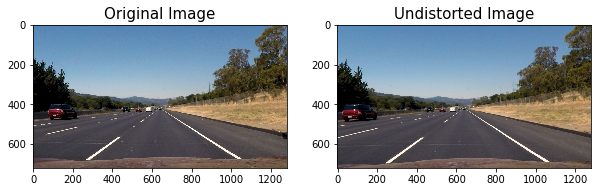

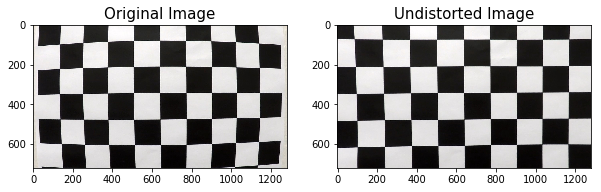

In [3]:
import matplotlib.image as mpimg
images = glob.glob('test_images/*.jpg')

def undistort_image(img):           
    result = cv2.undistort(img, mtx, dist, None, mtx)
    return result

# Step through the list and search for chessboard corners
undsts = []
for idx, fname in enumerate(images):
    img = mpimg.imread(fname)
    dst = undistort_image(img)
    undsts.append(dst)

numimg = 5
testimg = mpimg.imread(images[numimg])
undst_testimg = undsts[numimg]



f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.imshow(testimg)
ax1.set_title('Original Image', fontsize=15)
ax2.imshow(undst_testimg)
ax2.set_title('Undistorted Image', fontsize=15)


check = mpimg.imread("camera_cal/calibration1.jpg")
check_und = undistort_image(check)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.imshow(check)
ax1.set_title('Original Image', fontsize=15)
ax2.imshow(check_und)
ax2.set_title('Undistorted Image', fontsize=15)

plt.imsave("output_images/test1.jpg", undst_testimg)

### Visualize colorspace

Text(0.5, 1.0, 'HSV V')

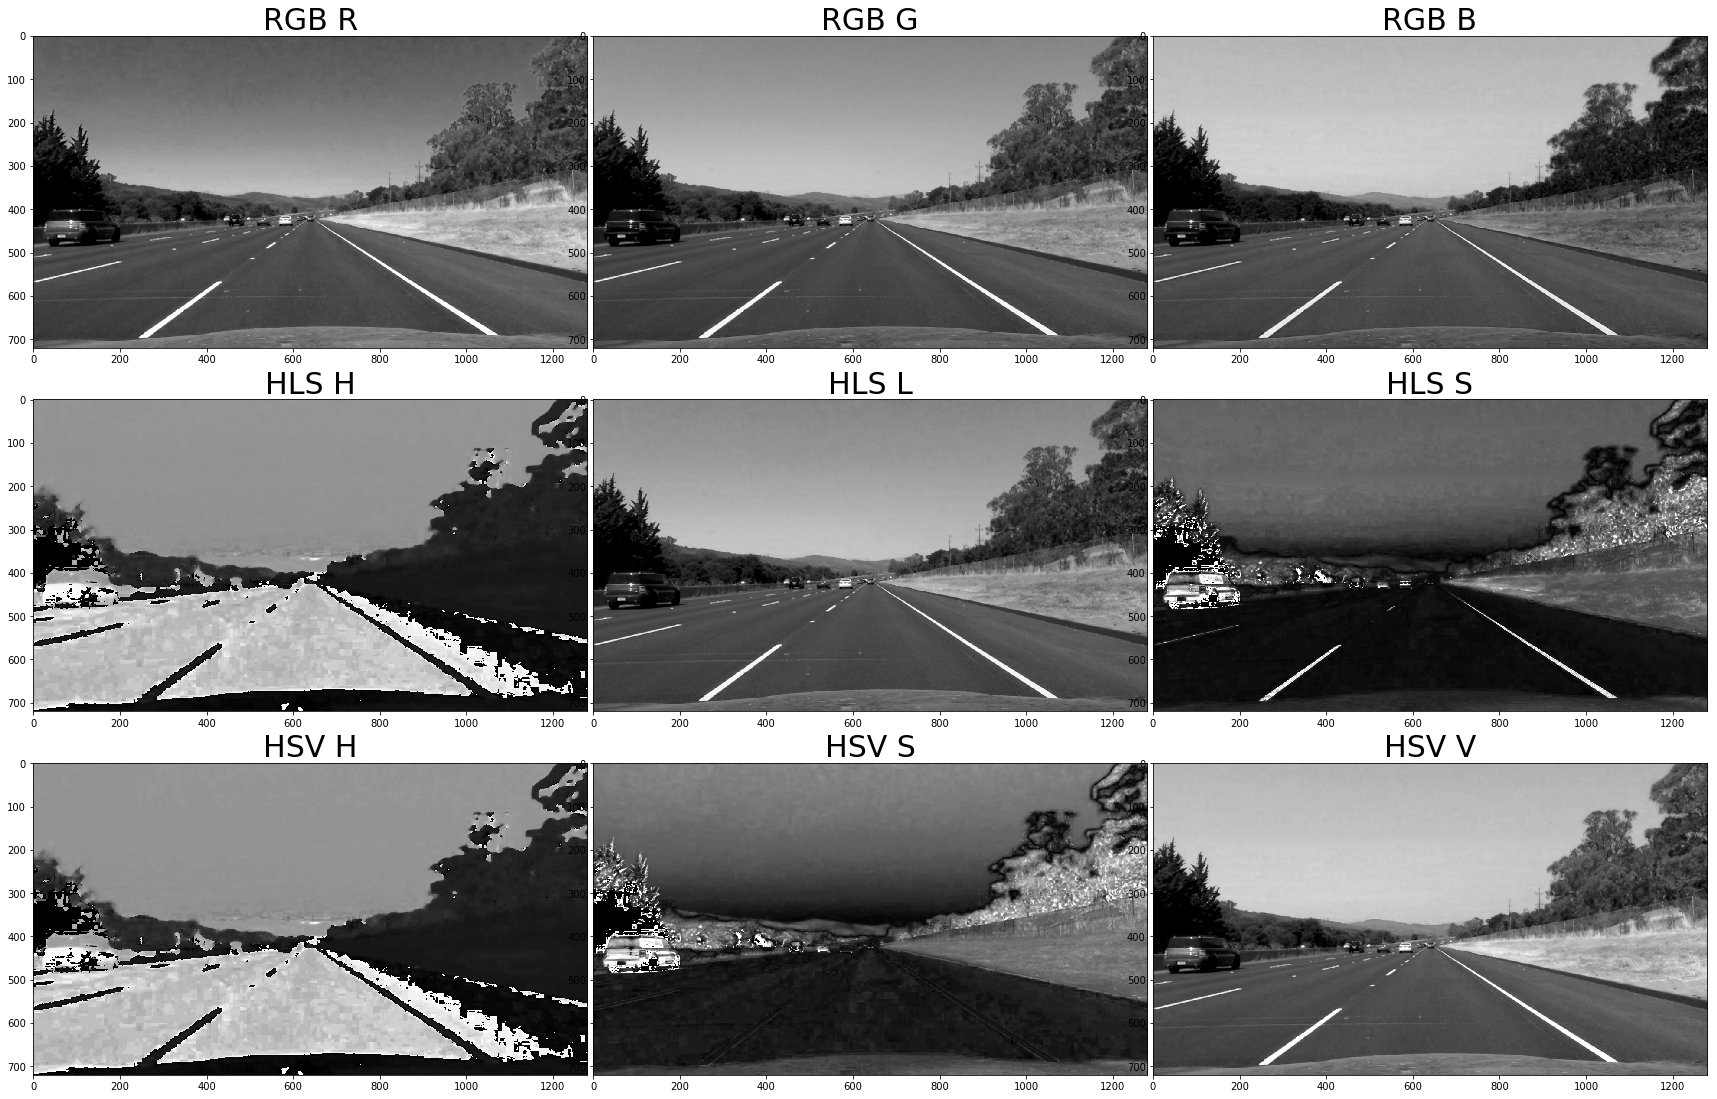

In [4]:
r_rgb_channel = undst_testimg[:,:,0]
g_rgb_channel = undst_testimg[:,:,1]
b_rgb_channel = undst_testimg[:,:,2]

hls = cv2.cvtColor(undst_testimg, cv2.COLOR_RGB2HLS)
h_hls_channel = hls[:,:,0]
l_hls_channel = hls[:,:,1]
s_hls_channel = hls[:,:,2]

hsv = cv2.cvtColor(undst_testimg, cv2.COLOR_RGB2HSV)
h_hsv_channel = hsv[:,:,0]
s_hsv_channel = hsv[:,:,1]
v_hsv_channel = hsv[:,:,2]

fig, axs = plt.subplots(3,3, figsize=(30, 20))
fig.subplots_adjust(hspace = .01, wspace=.01)
axs = axs.ravel()

axs[0].imshow(r_rgb_channel, cmap='gray')
axs[0].set_title('RGB R', fontsize=30)
axs[1].imshow(g_rgb_channel, cmap='gray')
axs[1].set_title('RGB G', fontsize=30)
axs[2].imshow(b_rgb_channel, cmap='gray')
axs[2].set_title('RGB B', fontsize=30)

axs[3].imshow(h_hls_channel, cmap='gray')
axs[3].set_title('HLS H', fontsize=30)
axs[4].imshow(l_hls_channel, cmap='gray')
axs[4].set_title('HLS L', fontsize=30)
axs[5].imshow(s_hls_channel, cmap='gray')
axs[5].set_title('HLS S', fontsize=30)

axs[6].imshow(h_hsv_channel, cmap='gray')
axs[6].set_title('HSV H', fontsize=30)
axs[7].imshow(s_hsv_channel, cmap='gray')
axs[7].set_title('HSV S', fontsize=30)
axs[8].imshow(v_hsv_channel, cmap='gray')
axs[8].set_title('HSV V', fontsize=30)


RGB-R HLS-L and HSV-V are recognizing both yellow and white lines so I will work with them

## Finding binary images

Text(0.5, 1.0, 'HSV v-binary')

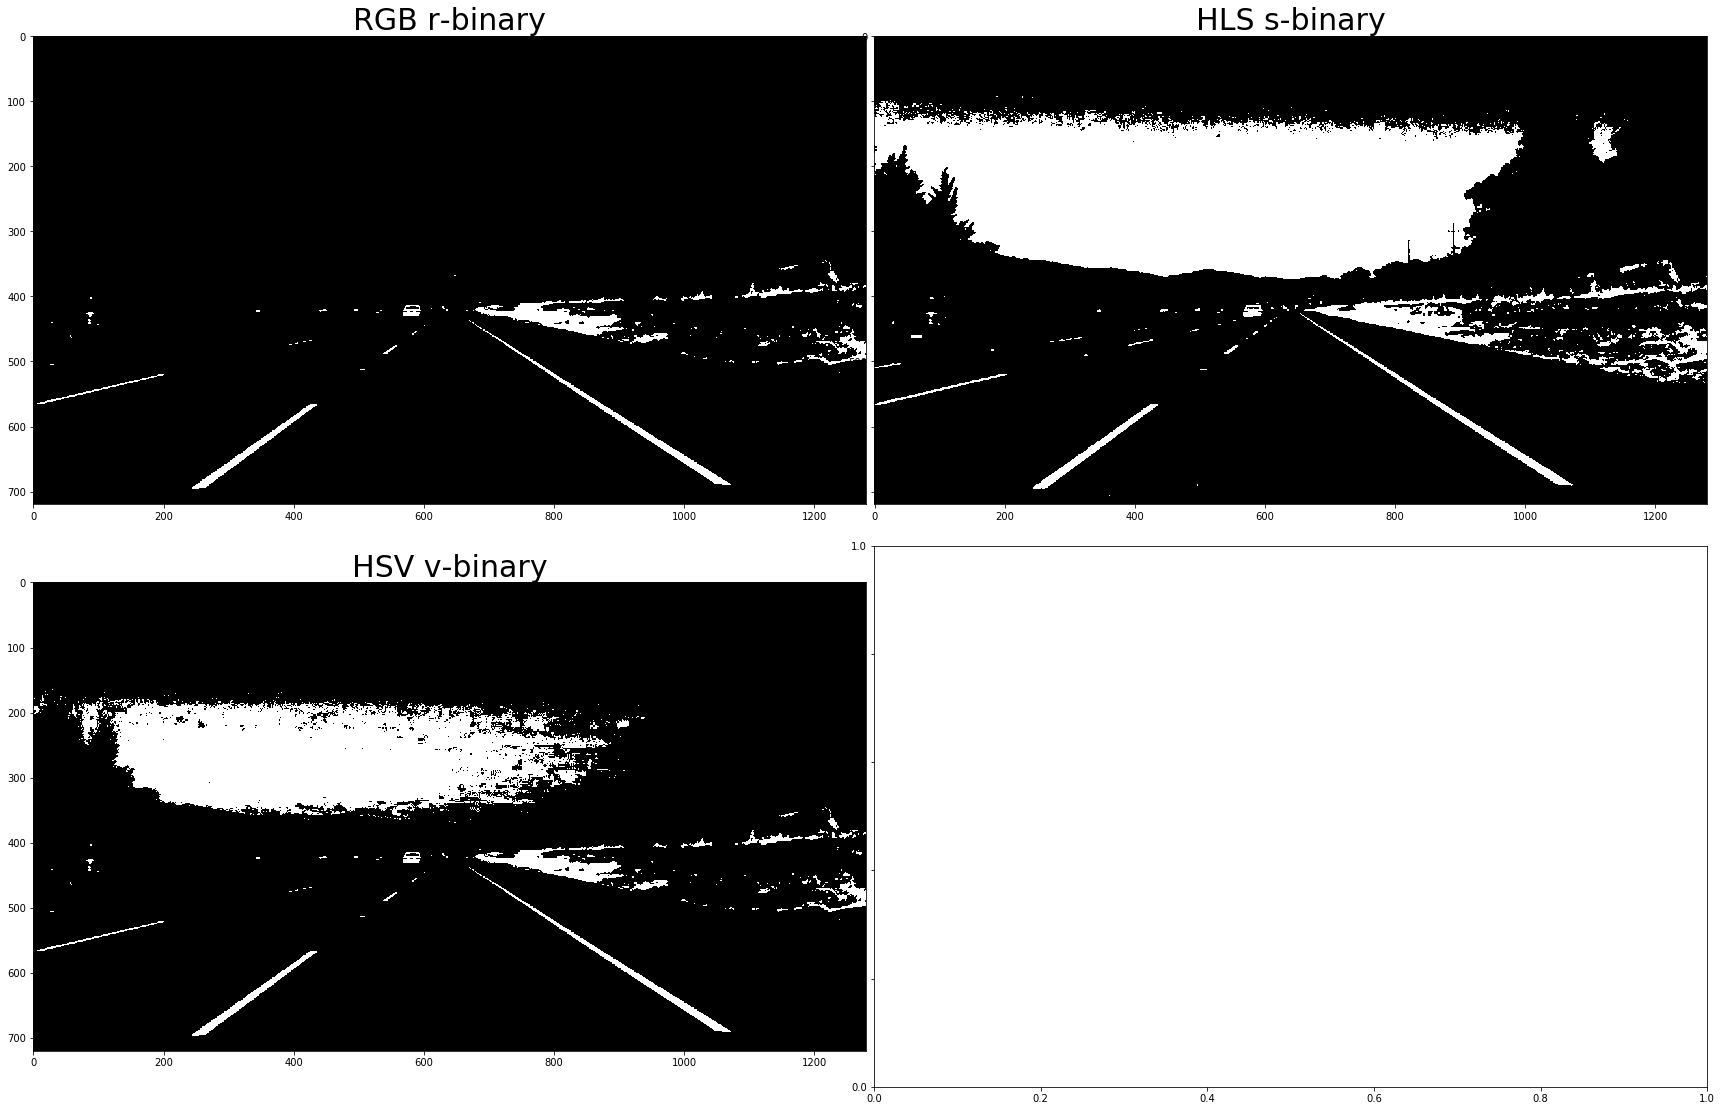

In [5]:
r_rgb_channel
r_rgb_thress = (200,255)
r_rgb_binary = np.zeros_like(r_rgb_channel)
r_rgb_binary[(r_rgb_channel > r_rgb_thress[0]) & (r_rgb_channel <= r_rgb_thress[1])] = 1


l_hls_channel
l_hls_thress = (150,255)
l_hls_binary = np.zeros_like(l_hls_channel)
l_hls_binary[(l_hls_channel > l_hls_thress[0]) & (l_hls_channel <= l_hls_thress[1])] = 1


v_hsv_channel
v_hsv_thress = (200,255)
v_hsv_binary = np.zeros_like(v_hsv_channel)
v_hsv_binary[(v_hsv_channel > v_hsv_thress[0]) & (v_hsv_channel <= v_hsv_thress[1])] = 1

fig, axs = plt.subplots(2,2, figsize=(30, 20))
fig.subplots_adjust(hspace = .01, wspace=.01)
axs = axs.ravel()

axs[0].imshow(r_rgb_binary, cmap='gray')
axs[0].set_title('RGB r-binary', fontsize=30)
axs[1].imshow(l_hls_binary, cmap='gray')
axs[1].set_title('HLS s-binary', fontsize=30)
axs[2].imshow(v_hsv_binary, cmap='gray')
axs[2].set_title('HSV v-binary', fontsize=30)

## Sobel Operator

Text(0.5, 1.0, 'grad_y_binary')

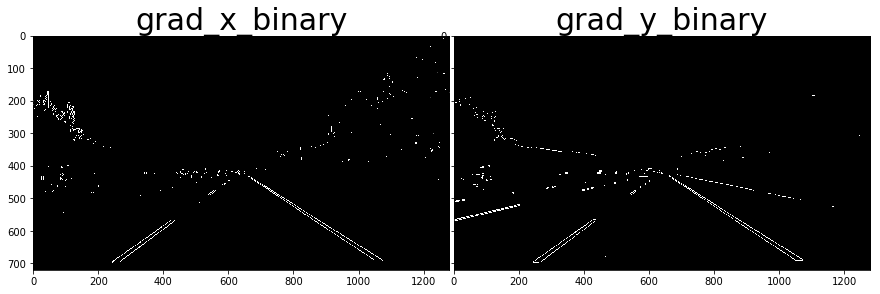

In [6]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

grad_x_binary = abs_sobel_thresh(undst_testimg , orient='x', thresh_min=60, thresh_max=150)
grad_y_binary = abs_sobel_thresh(undst_testimg , orient='y', thresh_min=90, thresh_max=255)

fig, axs = plt.subplots(1,2, figsize=(15, 10))
fig.subplots_adjust(hspace = .01, wspace=.01)
axs = axs.ravel()

axs[0].imshow(grad_x_binary, cmap='gray')
axs[0].set_title('grad_x_binary', fontsize=30)
axs[1].imshow(grad_y_binary, cmap='gray')
axs[1].set_title('grad_y_binary', fontsize=30)

## Magnitude of the gradient

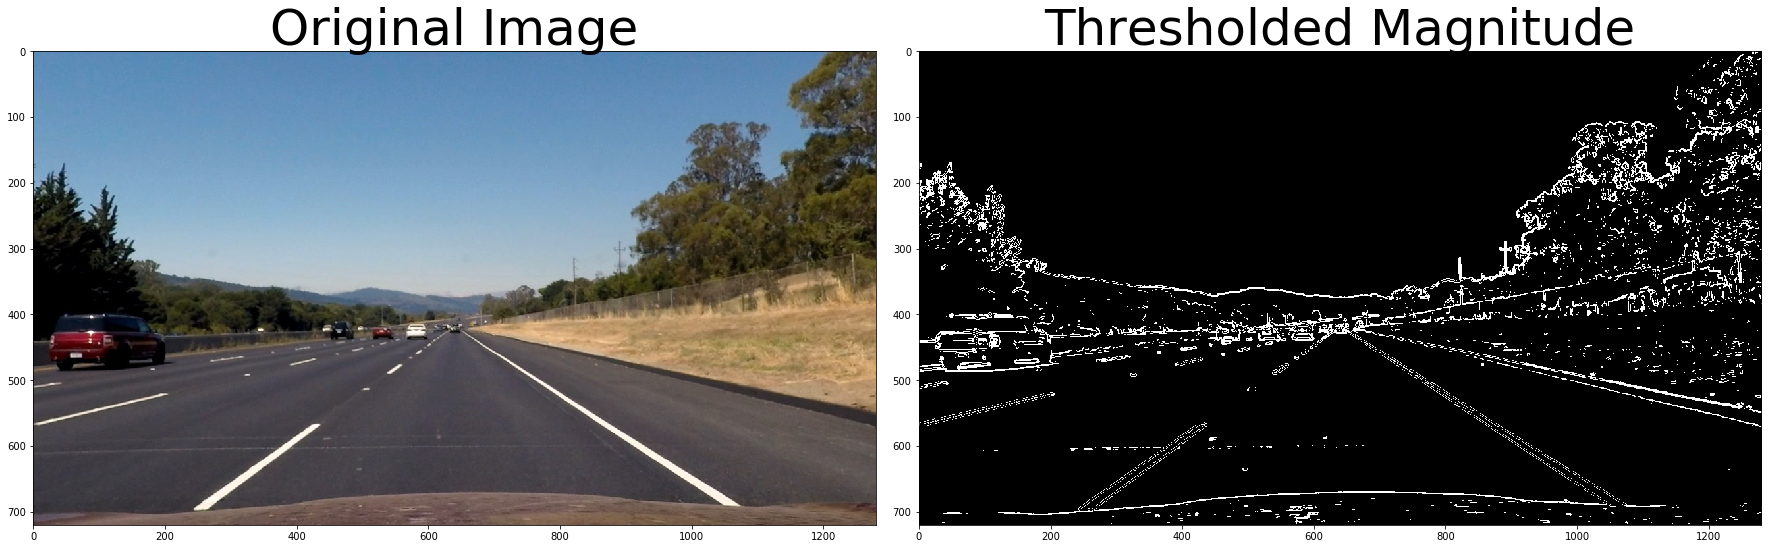

In [7]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

# Run the function
mag_binary = mag_thresh(undst_testimg, sobel_kernel=3, mag_thresh=(30, 100))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undst_testimg)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Direction of the gradient

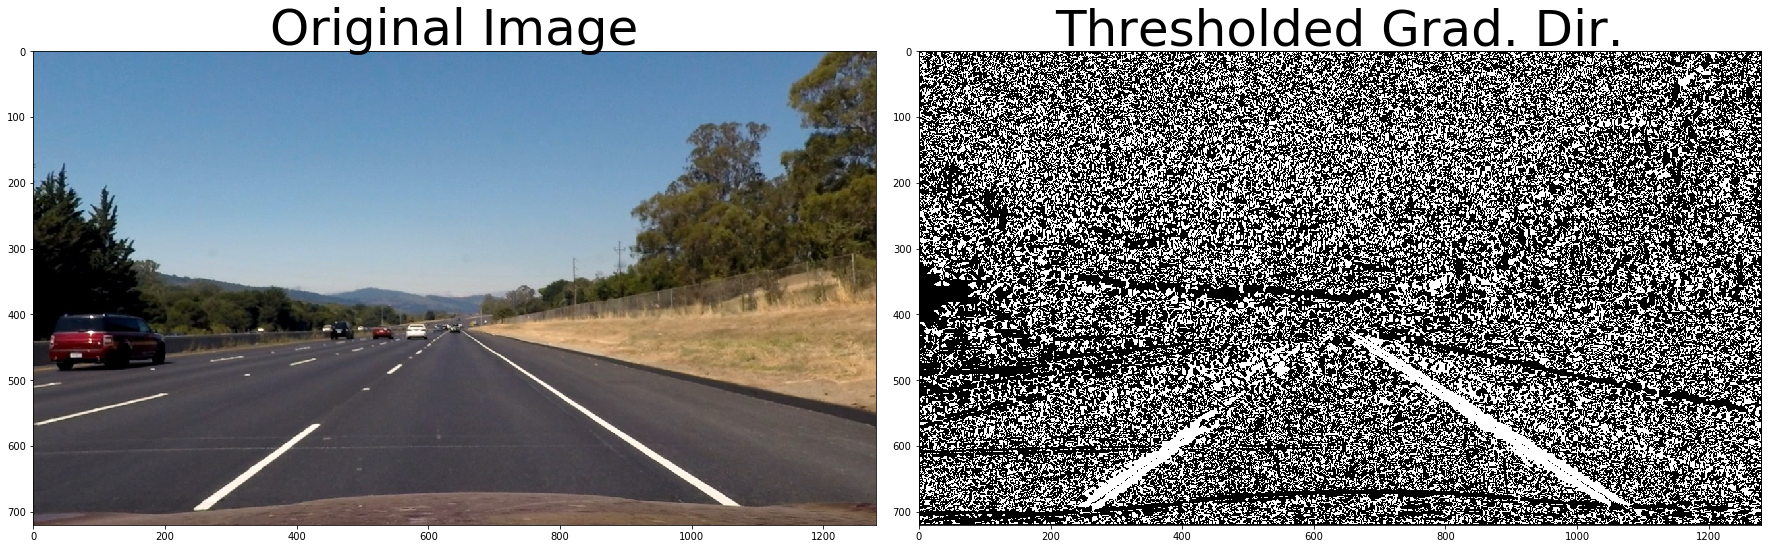

In [8]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Run the function
dir_binary = dir_threshold(undst_testimg, sobel_kernel=15, thresh=(0.7, 1.3))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undst_testimg)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Combining thressholds

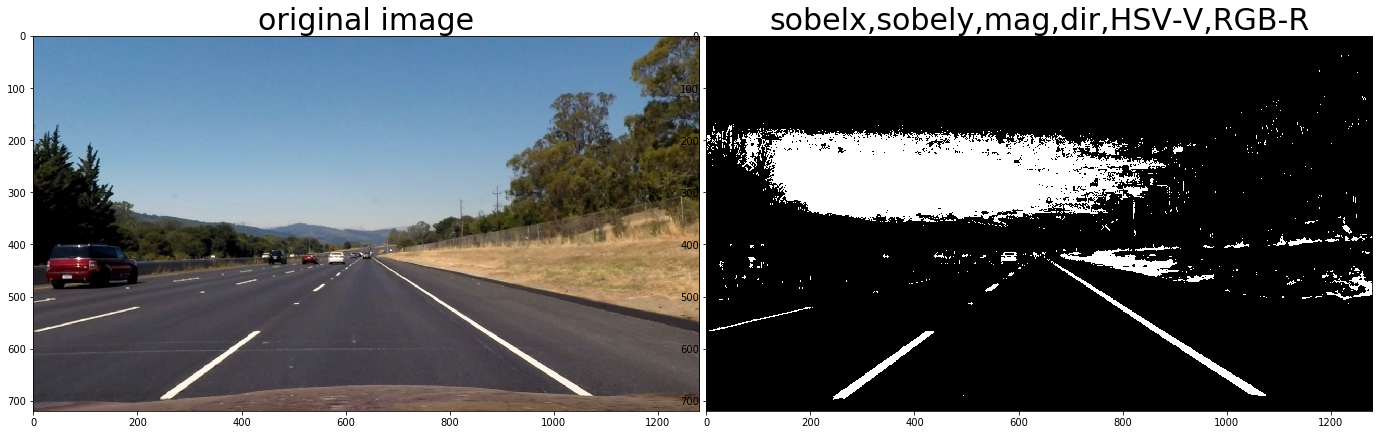

In [9]:
combined_binary = np.zeros_like(v_hsv_binary)
combined_threshold = np.zeros_like(dir_binary)
r_rgb_binary = np.zeros_like(r_rgb_channel)


###---- Apply sobelx,sobely, magnitude, and direction----
grad_x_binary = abs_sobel_thresh(undst_testimg , orient='x', thresh_min=60, thresh_max=150)
grad_y_binary = abs_sobel_thresh(undst_testimg , orient='y', thresh_min=90, thresh_max=255)

mag_binary = mag_thresh(undst_testimg, sobel_kernel = 9, mag_thresh = (120, 255))
dir_binary = dir_threshold(undst_testimg, sobel_kernel = 15, thresh = (0.7, 1.1))

combined_threshold = np.zeros_like(dir_binary)
combined_threshold[((grad_x_binary == 1) & (grad_x_binary == 1))| ((mag_binary == 1) & (dir_binary == 1)) ] = 1


#------RGB-R Channel binary---
r_rgb_thress = (200,255)
r_rgb_channel = undst_testimg[:,:,0]

r_rgb_binary = np.zeros_like(r_rgb_channel)
r_rgb_binary[(r_rgb_channel > r_rgb_thress[0]) & (r_rgb_channel <= r_rgb_thress[1])] = 1

#------HSV-V Channel binary---

hsv = cv2.cvtColor(undst_testimg, cv2.COLOR_RGB2HSV)
v_hsv_thress = (200,255)
v_hsv_channel = hsv[:,:,2]

v_hsv_binary[(v_hsv_channel > v_hsv_thress[0]) & (v_hsv_channel <= v_hsv_thress[1])] = 1
# color_binary = np.dstack((combined_threshold, combined_threshold, v_hsv_binary)) * 255
combined_binary = np.zeros_like(v_hsv_binary)
combined_binary[(r_rgb_binary == 1)| (v_hsv_binary == 1) | (combined_threshold == 1)] = 1



fig, axs = plt.subplots(1,2, figsize=(24, 9))
fig.subplots_adjust(hspace = .01, wspace=.01)
axs = axs.ravel()

axs[0].imshow(undst_testimg, cmap='gray')
axs[0].set_title('original image', fontsize = 30)

axs[1].imshow(combined_binary, cmap='gray')
axs[1].set_title('sobelx,sobely,mag,dir,HSV-V,RGB-R', fontsize = 30)


plt.imsave("examples/binary_combo_example.jpg", combined_binary)

combined_binary = np.zeros_like(v_hsv_binary)
combined_threshold = np.zeros_like(dir_binary)
r_rgb_binary = np.zeros_like(r_rgb_channel)

## Use color transforms, gradients, etc., to create a thresholded binary image.

Text(0.5, 1.0, 'Thressholded binary image-final')

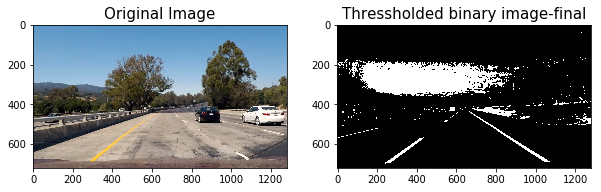

In [10]:
def pipeline(img, s_thresh=(160, 255), sx_thresh=(30, 100)):    
    img_copy = np.copy(img)
    undst = undistort_image(img_copy)
    ###---- Apply sobelx,sobely, magnitude, and direction----
    grad_x_binary1 = abs_sobel_thresh(undst , orient='x', thresh_min=60, thresh_max=150)
    grad_y_binary1 = abs_sobel_thresh(undst , orient='y', thresh_min=90, thresh_max=255)

    mag_binary1 = mag_thresh(undst, sobel_kernel = 9, mag_thresh = (120, 255))
    dir_binary1 = dir_threshold(undst, sobel_kernel = 15, thresh = (0.7, 1.1))

    combined_threshold1 = np.zeros_like(dir_binary1)
    combined_threshold1[((grad_x_binary1 == 1) & (grad_x_binary1 == 1))| ((mag_binary1 == 1) & (dir_binary1 == 1)) ] = 1


    #------RGB-R Channel binary---
    r_rgb_thress1 = (200,255)
    r_rgb_channel1 = undst[:,:,0]

    r_rgb_binary1 = np.zeros_like(r_rgb_channel1)
    r_rgb_binary1[(r_rgb_channel1 > r_rgb_thress1[0]) & (r_rgb_channel1 <= r_rgb_thress1[1])] = 1

    #------HSV-V Channel binary---

    hsv = cv2.cvtColor(undst, cv2.COLOR_RGB2HSV)
    v_hsv_thress1 = (200,255)
    v_hsv_channel1 = hsv[:,:,2]

    v_hsv_binary1 = np.zeros_like(v_hsv_channel1)
    v_hsv_binary1[(v_hsv_channel1 > v_hsv_thress1[0]) & (v_hsv_channel1 <= v_hsv_thress1[1])] = 1
#     color_binary = np.dstack((combined_threshold, combined_threshold, v_hsv_binary)) * 255
    combined_binary1 = np.zeros_like(v_hsv_binary1)
    combined_binary1[(r_rgb_binary1 == 1)| (v_hsv_binary1 == 1) | (combined_threshold1 == 1)] = 1
    
    return combined_binary1

thresholded = []

dst = pipeline(testimg)
thresholded.append(dst)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.imshow(img,cmap='gray')
ax1.set_title('Original Image', fontsize=15)
ax2.imshow(dst,cmap='gray')
ax2.set_title('Thressholded binary image-final', fontsize=15)

## Apply a perspective transform to rectify binary image ("birds-eye view").

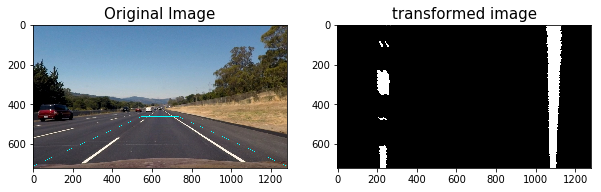

In [11]:
def transform(undst):
    offset = 0 # offset for dst points
    # Grab the image shape
    img_size = (undst.shape[1], undst.shape[0])
    w = undst.shape[1]
    h = undst.shape[0]

    # For source points I'm grabbing the outer four detected corners
    src = np.float32([[w, h - 10], [0, h - 10], [546,460], [732,460]])
    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result 
    # again, not exact, but close enough for our purposes
    dst = np.float32([[w, h], [0, h], [0, 0],[w, 0]])
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    inv_M = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(undst, M, img_size)
    
    

    return warped, M, inv_M

present_undst_testimg = np.copy(undst_testimg)
dst = pipeline(undst_testimg)
present_dst = pipeline(present_undst_testimg)

img_size = (present_dst.shape[1], present_dst.shape[0])
w = img_size[0]
h = img_size[1]
# For source points I'm grabbing the outer four detected corners
src = np.float32([[w, h - 10], [0, h - 10], [546,460], [732,460]])
pts = src.reshape((-1,1,2))
cv2.polylines(present_undst_testimg,np.int32([pts]),1,(0,255,255))
warpd_present, M_present, inv_M_present = transform(present_dst)



warpd, M, inv_M = transform(dst)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.imshow(present_undst_testimg)
ax1.set_title('Original Image', fontsize=15)
ax2.imshow(warpd_present,cmap="gray")
ax2.set_title('transformed image', fontsize=15)

# I'm creating a secondary set of photos for presentation only in order not to mess with the histogram.
plt.imsave("examples/warped_straight_lines.jpg", warpd_present)
plt.imsave("examples/area.jpg", present_undst_testimg)

## Histogram

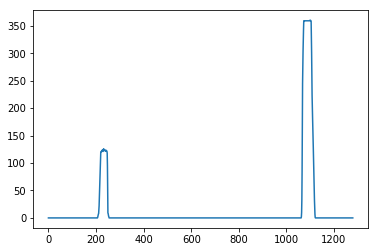

In [12]:
def hist(img):
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]
    # i.e. the highest areas of vertical lines should be larger values
    histogram = bottom_half.sum(axis=0)
    return histogram

# Create histogram of image binary activations

histogram = hist(warpd)

# Visualize the resulting histogram
plt.plot(histogram)

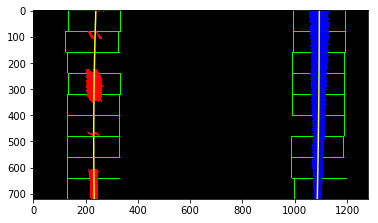

In [13]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit1 = np.polyfit(lefty, leftx, 2)
    right_fit1 = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit1[0]*ploty**2 + left_fit1[1]*ploty + left_fit1[2]
        right_fitx = right_fit1[0]*ploty**2 + right_fit1[1]*ploty + right_fit1[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img, ploty, left_fit1, right_fit1


out_img, ploty, left_fit1, right_fit1 = fit_polynomial(warpd)

plt.imshow(out_img)

## Detect lane pixels and fit to find the lane boundary.

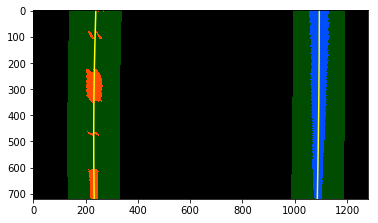

In [14]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped,left_fit,right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result

out_img = search_around_poly(warpd,left_fit1,right_fit1)

plt.imshow(out_img)

## Determine the curvature of the lane and vehicle position with respect to center.

In [15]:
def measure_curvature_pixels(fit,ploty):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    curverad = ((1 + (2*fit[0]*y_eval + fit[1])**2)**1.5) / np.absolute(2*fit[0])
    
    return curverad


# Calculate the radius of curvature in pixels for both lane lines
left_curverad, right_curverad = measure_curvature_pixels(left_fit1,ploty),measure_curvature_pixels(right_fit1,ploty)

print("Pixel space curvature:")
print(left_curverad, right_curverad)

def measure_curvature_real(fit,ploty):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 25/870 # meters per pixel in y dimension
    xm_per_pix = 3.7/850 # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    fit_x = fit[0]*ploty**2 + fit[1] * ploty + fit[2]
    
    fit_word_space = np.polyfit(ploty * ym_per_pix, fit_x* xm_per_pix, 2)
    
    ## Using measure_curvature_pixels but with the new polyfit
    result = measure_curvature_pixels(fit_word_space,  ploty)
    
    return result
    
    
    
    return left_curverad, right_curverad

def measure_offset(left_fit, right_fit, ploty, img):    
    ym_per_pix = 25/870 # meters per pixel in y dimension
    xm_per_pix = 3.7/850 # meters per pixel in x dimension
    xMax = img.shape[1]*xm_per_pix
    yMax = img.shape[0]*ym_per_pix
    vehicleCenter = xMax / 2

    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Fit a second order polynomial to each
    left_fit_m = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_m = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    
    lineLeft = left_fit_m[0]*yMax**2 + left_fit_m[1]*yMax + left_fit_m[2]
    lineRight = right_fit_m[0]*yMax**2 + right_fit_m[1]*yMax + right_fit_m[2]
    lineMiddle = lineLeft + (lineRight - lineLeft)/2
    diffFromVehicle = lineMiddle - vehicleCenter
    
    return diffFromVehicle



# Calculate the radius of curvature in meters for both lane lines
left_curverad, right_curverad = measure_curvature_real(left_fit1,ploty), measure_curvature_real(right_fit1,ploty)
print("World space curvature:")
print(left_curverad, 'm', right_curverad, 'm')
print(measure_offset(left_fit1,right_fit1,ploty,undst_testimg))
# Should see values of 533.75 and 648.16 here, if using
# the default `generate_data` function with given seed number

Pixel space curvature:
14849.737665502813 37648.93186141266
World space curvature:
3084.709270294362 m 7246.765822526117 m
0.08533684704273048


## Warp the detected lane boundaries back onto the original image.

In [16]:
def from_previous(binary_warped, fit_left, fit_right):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (fit_left[0]*(nonzeroy**2) + fit_left[1]*nonzeroy + 
                    fit_left[2] - margin)) & (nonzerox < (fit_left[0]*(nonzeroy**2) + 
                    fit_left[1]*nonzeroy + fit_left[2] + margin)))
    right_lane_inds = ((nonzerox > (fit_right[0]*(nonzeroy**2) + fit_right[1]*nonzeroy + 
                    fit_right[2] - margin)) & (nonzerox < (fit_right[0]*(nonzeroy**2) + 
                    fit_right[1]*nonzeroy + fit_right[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        fit_left1 = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        fit_right1 = np.polyfit(righty, rightx, 2)
    
    return fit_left1, fit_right1

Text(0.5, 1.0, 'transformed image')

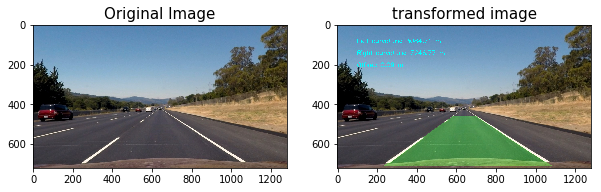

In [17]:
#DOESNT WORK YET!
def drawUnwarped(undistorted_img, warped_img_bin, left_fit, right_fit, inv_M, img_size):
    ploty = np.linspace(0, warped_img_bin.shape[0] - 1, warped_img_bin.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    warp_zero = np.zeros_like(warped_img_bin).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    left_curverad, right_curverad = measure_curvature_real(left_fit,ploty),measure_curvature_real(right_fit,ploty)

    curvature_string_l = "Left curvature: %.2f m" % left_curverad
    
    curvature_string_r = "Right curvature: %.2f m" % right_curverad
    
    offset_string = "Offset: %.2f m" % measure_offset(left_fit,right_fit,ploty,undistorted_img)
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, inv_M, img_size) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted_img, 1, newwarp, 0.3, 0)
    cv2.putText(result,curvature_string_l , (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,255), thickness=2)    
    cv2.putText(result,curvature_string_r , (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,255), thickness=2)
    cv2.putText(result, offset_string, (100, 210), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,255), thickness=2)

    return result


# rgb_test_img = cv2.cvtColor(testimg, cv2.COLOR_BGR2RGB)

undistort_test_img = undistort_image(testimg)
binary_warped = pipeline(undistort_test_img)
warpd, M, inv_M = transform(dst)
img_size = (undistort_test_img.shape[1], undistort_test_img.shape[0])

result = drawUnwarped(undistort_test_img, binary_warped, left_fit1, right_fit1, inv_M, img_size)
plt.imsave("output_images/test_img_1_output.jpg", result)

# testimg2 = mpimg.imread(images[1])
# testimg3 = mpimg.imread(images[2])

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.imshow(undistort_test_img)
ax1.set_title('Original Image', fontsize=15)
ax2.imshow(result)
ax2.set_title('transformed image', fontsize=15)

In [18]:
polyfit_left = None
polyfit_right = None

def process_image(image):
    # global variables to store the polynomial coefficients of the line detected in the last frame
    global polyfit_left
    global polyfit_right
    
    img_size = (image.shape[1], image.shape[0])

    #1. Camera correction and distortion correction
    undistorted_img = undistort_image(image)

    # Process pipeline and produce warped image
    dst = pipeline(undistorted_img)
    warped_img_binary, M, inv_M = transform(dst)
    
    if (polyfit_left is not None) and (polyfit_right is not None):
        polyfit_left, polyfit_right= from_previous(warped_img_binary, polyfit_left, polyfit_right)
    else:
        ##sliding_window
        out_img, ploty, polyfit_left, polyfit_right = fit_polynomial(warped_img_binary)
    ##Draw
    result = drawUnwarped(undistorted_img,warped_img_binary,polyfit_left, polyfit_right, inv_M, img_size)

    return result

## Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

t:   0%|          | 2/1260 [00:00<01:40, 12.48it/s, now=None]

Moviepy - Building video output_videos/project_video.mp4.
Moviepy - Writing video output_videos/project_video.mp4



Moviepy - Done !
Moviepy - video ready output_videos/project_video.mp4
CPU times: user 6min 20s, sys: 9.41 s, total: 6min 29s
Wall time: 3min 10s


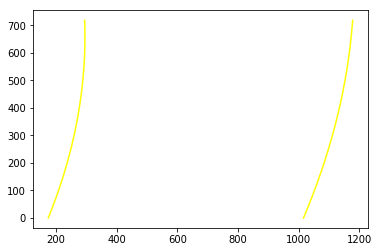

In [19]:
from moviepy.editor import VideoFileClip

polyfit_left = None
polyfit_right = None

clip1 = VideoFileClip('project_video.mp4')
video_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!

video_output = 'output_videos/project_video.mp4'
%time video_clip.write_videofile(video_output, audio=False)